In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("Terry_Stops_20250719.csv")
df.head()

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
0,46 - 55,-1,2.020000e+13,481899,Field Contact,NaN,8544,1993,Female,Hispanic,...,47:00.0,-,-,-,NORTH PCT 2ND WATCH - B/N RELIEF,N,N,West,Q,Q2
1,18 - 25,-1,2.020000e+13,445585,Offense Report,NaN,8588,1986,Female,White,...,43:00.0,"OBS WEAPN-IP/JO-GUN,DEADLY WPN (NO THRT/ASLT/D...","WEAPON, PERSON WITH - GUN",911,TRAINING - FIELD TRAINING SQUAD,N,Y,North,J,J1
2,26 - 35,-1,2.020000e+13,234548,Offense Report,NaN,4852,1953,Male,Asian,...,36:00.0,DISTURBANCE,THEFT - SHOPLIFT,911,NORTH PCT 2ND W - LINCOLN - PLATOON 1,N,N,North,L,L3
3,36 - 45,49326761681,2.020000e+13,49327076666,Field Contact,Knife/Cutting/Stabbing Instrument,7766,1984,Male,White,...,25:58.0,OBS - DOWN - CHECK FOR PERSON DOWN,SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,WEST PCT 1ST W - QUEEN (DAVID) - PLATOON 1,N,Y,West,K,K3
4,Jan-17,48319519002,2.020000e+13,48319446887,Field Contact,-,8765,1992,Male,Two or More Races,...,53:15.0,MVC - HIT AND RUN,TRAFFIC - MV COLLISION INVESTIGATION,911,SOUTH PCT 3RD W - ROBERT (OCEAN) - PLATOON 1,N,N,South,R,R2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64186 entries, 0 to 64185
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Subject Age Group         64186 non-null  object 
 1   Subject ID                64186 non-null  int64  
 2   GO / SC Num               64186 non-null  float64
 3   Terry Stop ID             64186 non-null  int64  
 4   Stop Resolution           64186 non-null  object 
 5   Weapon Type               31621 non-null  object 
 6   Officer ID                64186 non-null  object 
 7   Officer YOB               64186 non-null  int64  
 8   Officer Gender            64186 non-null  object 
 9   Officer Race              64186 non-null  object 
 10  Subject Perceived Race    64186 non-null  object 
 11  Subject Perceived Gender  64186 non-null  object 
 12  Reported Date             64186 non-null  object 
 13  Reported Time             64186 non-null  object 
 14  Initia

In [4]:
df.isnull().sum()

Subject Age Group               0
Subject ID                      0
GO / SC Num                     0
Terry Stop ID                   0
Stop Resolution                 0
Weapon Type                 32565
Officer ID                      0
Officer YOB                     0
Officer Gender                  0
Officer Race                    0
Subject Perceived Race          0
Subject Perceived Gender        0
Reported Date                   0
Reported Time                   0
Initial Call Type               0
Final Call Type                 0
Call Type                       0
Officer Squad                 563
Arrest Flag                     0
Frisk Flag                      0
Precinct                        0
Sector                          0
Beat                            0
dtype: int64

- Weapon Type is missing a lot of values and might be relevant to model-building.
- Check its importance before building a model and assess whether imputation or dropping it completely is the right move

In [5]:
missing_percent = df['Weapon Type'].isnull().mean() * 100
print(f"Missing: {missing_percent:.2f}%")


Missing: 50.74%


In [7]:
df['Weapon Type Missing'] = df['Weapon Type'].isnull().astype(int)
df

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat,Weapon Type Missing
0,46 - 55,-1,2.020000e+13,481899,Field Contact,NaN,8544,1993,Female,Hispanic,...,-,-,-,NORTH PCT 2ND WATCH - B/N RELIEF,N,N,West,Q,Q2,1
1,18 - 25,-1,2.020000e+13,445585,Offense Report,NaN,8588,1986,Female,White,...,"OBS WEAPN-IP/JO-GUN,DEADLY WPN (NO THRT/ASLT/D...","WEAPON, PERSON WITH - GUN",911,TRAINING - FIELD TRAINING SQUAD,N,Y,North,J,J1,1
2,26 - 35,-1,2.020000e+13,234548,Offense Report,NaN,4852,1953,Male,Asian,...,DISTURBANCE,THEFT - SHOPLIFT,911,NORTH PCT 2ND W - LINCOLN - PLATOON 1,N,N,North,L,L3,1
3,36 - 45,49326761681,2.020000e+13,49327076666,Field Contact,Knife/Cutting/Stabbing Instrument,7766,1984,Male,White,...,OBS - DOWN - CHECK FOR PERSON DOWN,SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,WEST PCT 1ST W - QUEEN (DAVID) - PLATOON 1,N,Y,West,K,K3,0
4,Jan-17,48319519002,2.020000e+13,48319446887,Field Contact,-,8765,1992,Male,Two or More Races,...,MVC - HIT AND RUN,TRAFFIC - MV COLLISION INVESTIGATION,911,SOUTH PCT 3RD W - ROBERT (OCEAN) - PLATOON 1,N,N,South,R,R2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64181,26 - 35,7738643372,2.020000e+13,19551625274,Field Contact,-,8486,1992,Male,Asian,...,ASLT - DV,DV - DOMESTIC VIOL/ASLT (ARREST MANDATORY),"TELEPHONE OTHER, NOT 911",SOUTHWEST PCT 2ND W - FRANK - PLATOON 2,N,N,Southwest,F,F1,0
64182,26 - 35,-1,2.020000e+13,199148,Arrest,NaN,8337,1984,Male,Two or More Races,...,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,WARRANT SERVICES - MISDEMEANOR,ONVIEW,NORTH PCT 1ST W - BOY (JOHN) - PLATOON 1,N,Y,North,B,B2,1
64183,26 - 35,-1,2.020000e+13,343990,Arrest,NaN,8518,1987,Male,Asian,...,OBS - DOWN - CHECK FOR PERSON DOWN,SUSPICIOUS CIRCUM. - SUSPICIOUS VEHICLE,911,TRAINING - FIELD TRAINING SQUAD,N,Y,North,L,L2,1
64184,36 - 45,13852686838,2.020000e+13,57880886680,Field Contact,-,8769,1995,Male,Declined to Answer,...,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,EAST PCT 3RD W - EDWARD (CHARLIE) - PLATOON 1,N,N,East,E,E2,0


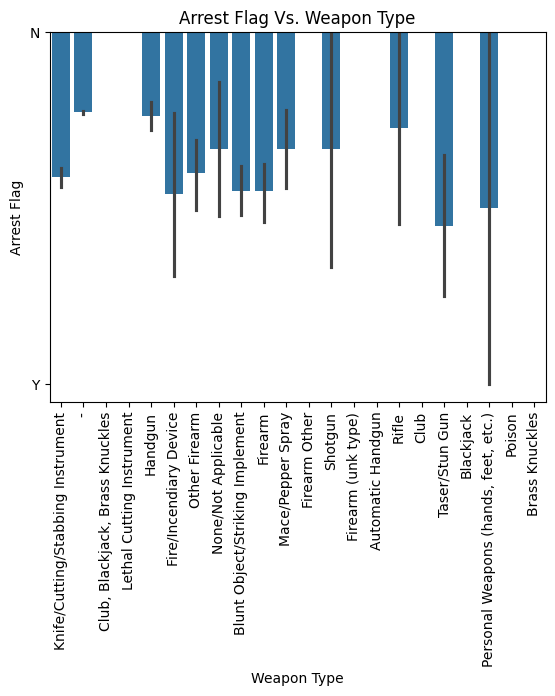

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='Weapon Type', y='Arrest Flag', data=df)
plt.title("Arrest Flag Vs. Weapon Type")
plt.xticks(rotation=90)
plt.show()


In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

model_missing_only = RandomForestClassifier(random_state=42)
score_missing_only = cross_val_score(
    model_missing_only,
    df[['Weapon_Type_missing']],
    df['Arrest Flag'],
    cv=5
).mean()

print(f"Score using only missingness indicator: {score_missing_only:.4f}")


Score using only missingness indicator: 0.8874


In [24]:
df_notnull = df.dropna(subset=['Weapon Type'])

# One-hot encode Weapon Type
X_weapon_encoded = pd.get_dummies(df_notnull[['Weapon Type']], drop_first=True)
y_notnull = df_notnull['Arrest Flag']

model_encoded = RandomForestClassifier(random_state=42)
score_encoded = cross_val_score(
    model_encoded,
    X_weapon_encoded,
    y_notnull,
    cv=5
).mean()

print(f"Score using actual Weapon Type values (non-missing): {score_encoded:.4f}")


Score using actual Weapon Type values (non-missing): 0.7712


In [23]:
df['Weapon_Type_filled'] = df['Weapon Type'].fillna('Unknown')
X_full_encoded = pd.get_dummies(df[['Weapon_Type_filled']], drop_first=True)

model_imputed = RandomForestClassifier(random_state=42)
score_imputed = cross_val_score(
    model_imputed,
    X_full_encoded,
    df['Arrest Flag'],
    cv=5
).mean()

print(f"Score after imputing and encoding Weapon Type: {score_imputed:.4f}")


Score after imputing and encoding Weapon Type: 0.8870


### Model Comparison Results
| Model Version                                  | CV Score   | Interpretation                                                            |
| ---------------------------------------------- | ---------- | ------------------------------------------------------------------------- |
|  **Missingness indicator only**               | **0.8874** | Highest score — strong signal just from whether the value is missing.     |
|  **Actual Weapon Type values** (no missing) | 0.7712     | Much lower — actual values are *less predictive* than missingness itself. |
|  **Imputed + Encoded Weapon Type**            | 0.8870     | Almost same as missingness only — imputation doesn't add useful signal.   |  

- Missingness > Actual Data:

    - The fact that Weapon Type is missing tells the model more about arrest likelihood than the actual weapon type does.

    - Possibly: unreported weapon types are correlated with non-arrests.

- Imputing Doesn’t Improve the Model

- Best Option for Modeling:

    - Keep the missingness indicator as a feature "Weapon_Type_missing" and drop the "Weapon Type" column


In [25]:
df

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat,Weapon_Type_missing,Weapon_Type_filled
0,46 - 55,-1,2.020000e+13,481899,Field Contact,NaN,8544,1993,Female,Hispanic,...,-,-,NORTH PCT 2ND WATCH - B/N RELIEF,N,N,West,Q,Q2,1,Unknown
1,18 - 25,-1,2.020000e+13,445585,Offense Report,NaN,8588,1986,Female,White,...,"WEAPON, PERSON WITH - GUN",911,TRAINING - FIELD TRAINING SQUAD,N,Y,North,J,J1,1,Unknown
2,26 - 35,-1,2.020000e+13,234548,Offense Report,NaN,4852,1953,Male,Asian,...,THEFT - SHOPLIFT,911,NORTH PCT 2ND W - LINCOLN - PLATOON 1,N,N,North,L,L3,1,Unknown
3,36 - 45,49326761681,2.020000e+13,49327076666,Field Contact,Knife/Cutting/Stabbing Instrument,7766,1984,Male,White,...,SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,WEST PCT 1ST W - QUEEN (DAVID) - PLATOON 1,N,Y,West,K,K3,0,Knife/Cutting/Stabbing Instrument
4,Jan-17,48319519002,2.020000e+13,48319446887,Field Contact,-,8765,1992,Male,Two or More Races,...,TRAFFIC - MV COLLISION INVESTIGATION,911,SOUTH PCT 3RD W - ROBERT (OCEAN) - PLATOON 1,N,N,South,R,R2,0,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64181,26 - 35,7738643372,2.020000e+13,19551625274,Field Contact,-,8486,1992,Male,Asian,...,DV - DOMESTIC VIOL/ASLT (ARREST MANDATORY),"TELEPHONE OTHER, NOT 911",SOUTHWEST PCT 2ND W - FRANK - PLATOON 2,N,N,Southwest,F,F1,0,-
64182,26 - 35,-1,2.020000e+13,199148,Arrest,NaN,8337,1984,Male,Two or More Races,...,WARRANT SERVICES - MISDEMEANOR,ONVIEW,NORTH PCT 1ST W - BOY (JOHN) - PLATOON 1,N,Y,North,B,B2,1,Unknown
64183,26 - 35,-1,2.020000e+13,343990,Arrest,NaN,8518,1987,Male,Asian,...,SUSPICIOUS CIRCUM. - SUSPICIOUS VEHICLE,911,TRAINING - FIELD TRAINING SQUAD,N,Y,North,L,L2,1,Unknown
64184,36 - 45,13852686838,2.020000e+13,57880886680,Field Contact,-,8769,1995,Male,Declined to Answer,...,SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,EAST PCT 3RD W - EDWARD (CHARLIE) - PLATOON 1,N,N,East,E,E2,0,-


In [26]:
features = [..., 'Weapon_Type_missing']  # include it
df.drop(columns=['Weapon Type', 'Weapon_Type_filled'], inplace=True)  #drop

In [27]:
df

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Officer ID,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,...,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat,Weapon_Type_missing
0,46 - 55,-1,2.020000e+13,481899,Field Contact,8544,1993,Female,Hispanic,White,...,-,-,-,NORTH PCT 2ND WATCH - B/N RELIEF,N,N,West,Q,Q2,1
1,18 - 25,-1,2.020000e+13,445585,Offense Report,8588,1986,Female,White,Black or African American,...,"OBS WEAPN-IP/JO-GUN,DEADLY WPN (NO THRT/ASLT/D...","WEAPON, PERSON WITH - GUN",911,TRAINING - FIELD TRAINING SQUAD,N,Y,North,J,J1,1
2,26 - 35,-1,2.020000e+13,234548,Offense Report,4852,1953,Male,Asian,White,...,DISTURBANCE,THEFT - SHOPLIFT,911,NORTH PCT 2ND W - LINCOLN - PLATOON 1,N,N,North,L,L3,1
3,36 - 45,49326761681,2.020000e+13,49327076666,Field Contact,7766,1984,Male,White,Native Hawaiian or Other Pacific Islander,...,OBS - DOWN - CHECK FOR PERSON DOWN,SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,WEST PCT 1ST W - QUEEN (DAVID) - PLATOON 1,N,Y,West,K,K3,0
4,Jan-17,48319519002,2.020000e+13,48319446887,Field Contact,8765,1992,Male,Two or More Races,Black or African American,...,MVC - HIT AND RUN,TRAFFIC - MV COLLISION INVESTIGATION,911,SOUTH PCT 3RD W - ROBERT (OCEAN) - PLATOON 1,N,N,South,R,R2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64181,26 - 35,7738643372,2.020000e+13,19551625274,Field Contact,8486,1992,Male,Asian,American Indian or Alaska Native,...,ASLT - DV,DV - DOMESTIC VIOL/ASLT (ARREST MANDATORY),"TELEPHONE OTHER, NOT 911",SOUTHWEST PCT 2ND W - FRANK - PLATOON 2,N,N,Southwest,F,F1,0
64182,26 - 35,-1,2.020000e+13,199148,Arrest,8337,1984,Male,Two or More Races,White,...,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,WARRANT SERVICES - MISDEMEANOR,ONVIEW,NORTH PCT 1ST W - BOY (JOHN) - PLATOON 1,N,Y,North,B,B2,1
64183,26 - 35,-1,2.020000e+13,343990,Arrest,8518,1987,Male,Asian,Unknown,...,OBS - DOWN - CHECK FOR PERSON DOWN,SUSPICIOUS CIRCUM. - SUSPICIOUS VEHICLE,911,TRAINING - FIELD TRAINING SQUAD,N,Y,North,L,L2,1
64184,36 - 45,13852686838,2.020000e+13,57880886680,Field Contact,8769,1995,Male,Declined to Answer,White,...,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,EAST PCT 3RD W - EDWARD (CHARLIE) - PLATOON 1,N,N,East,E,E2,0


In [30]:
df.isnull().sum()

Subject Age Group             0
Subject ID                    0
GO / SC Num                   0
Terry Stop ID                 0
Stop Resolution               0
Officer ID                    0
Officer YOB                   0
Officer Gender                0
Officer Race                  0
Subject Perceived Race        0
Subject Perceived Gender      0
Reported Date                 0
Reported Time                 0
Initial Call Type             0
Final Call Type               0
Call Type                     0
Officer Squad               563
Arrest Flag                   0
Frisk Flag                    0
Precinct                      0
Sector                        0
Beat                          0
Weapon_Type_missing           0
dtype: int64

In [38]:
df["Officer Squad"].mode()

0    TRAINING - FIELD TRAINING SQUAD
Name: Officer Squad, dtype: object

In [42]:
df["Officer Squad"].fillna(df["Officer Squad"].mode()[0], inplace = True)

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64186 entries, 0 to 64185
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Subject Age Group         64186 non-null  object 
 1   Subject ID                64186 non-null  int64  
 2   GO / SC Num               64186 non-null  float64
 3   Terry Stop ID             64186 non-null  int64  
 4   Stop Resolution           64186 non-null  object 
 5   Officer ID                64186 non-null  object 
 6   Officer YOB               64186 non-null  int64  
 7   Officer Gender            64186 non-null  object 
 8   Officer Race              64186 non-null  object 
 9   Subject Perceived Race    64186 non-null  object 
 10  Subject Perceived Gender  64186 non-null  object 
 11  Reported Date             64186 non-null  object 
 12  Reported Time             64186 non-null  object 
 13  Initial Call Type         64186 non-null  object 
 14  Final 

In [44]:
df.drop_duplicates()

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Officer ID,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,...,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat,Weapon_Type_missing
0,46 - 55,-1,2.020000e+13,481899,Field Contact,8544,1993,Female,Hispanic,White,...,-,-,-,NORTH PCT 2ND WATCH - B/N RELIEF,N,N,West,Q,Q2,1
1,18 - 25,-1,2.020000e+13,445585,Offense Report,8588,1986,Female,White,Black or African American,...,"OBS WEAPN-IP/JO-GUN,DEADLY WPN (NO THRT/ASLT/D...","WEAPON, PERSON WITH - GUN",911,TRAINING - FIELD TRAINING SQUAD,N,Y,North,J,J1,1
2,26 - 35,-1,2.020000e+13,234548,Offense Report,4852,1953,Male,Asian,White,...,DISTURBANCE,THEFT - SHOPLIFT,911,NORTH PCT 2ND W - LINCOLN - PLATOON 1,N,N,North,L,L3,1
3,36 - 45,49326761681,2.020000e+13,49327076666,Field Contact,7766,1984,Male,White,Native Hawaiian or Other Pacific Islander,...,OBS - DOWN - CHECK FOR PERSON DOWN,SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,WEST PCT 1ST W - QUEEN (DAVID) - PLATOON 1,N,Y,West,K,K3,0
4,Jan-17,48319519002,2.020000e+13,48319446887,Field Contact,8765,1992,Male,Two or More Races,Black or African American,...,MVC - HIT AND RUN,TRAFFIC - MV COLLISION INVESTIGATION,911,SOUTH PCT 3RD W - ROBERT (OCEAN) - PLATOON 1,N,N,South,R,R2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64181,26 - 35,7738643372,2.020000e+13,19551625274,Field Contact,8486,1992,Male,Asian,American Indian or Alaska Native,...,ASLT - DV,DV - DOMESTIC VIOL/ASLT (ARREST MANDATORY),"TELEPHONE OTHER, NOT 911",SOUTHWEST PCT 2ND W - FRANK - PLATOON 2,N,N,Southwest,F,F1,0
64182,26 - 35,-1,2.020000e+13,199148,Arrest,8337,1984,Male,Two or More Races,White,...,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,WARRANT SERVICES - MISDEMEANOR,ONVIEW,NORTH PCT 1ST W - BOY (JOHN) - PLATOON 1,N,Y,North,B,B2,1
64183,26 - 35,-1,2.020000e+13,343990,Arrest,8518,1987,Male,Asian,Unknown,...,OBS - DOWN - CHECK FOR PERSON DOWN,SUSPICIOUS CIRCUM. - SUSPICIOUS VEHICLE,911,TRAINING - FIELD TRAINING SQUAD,N,Y,North,L,L2,1
64184,36 - 45,13852686838,2.020000e+13,57880886680,Field Contact,8769,1995,Male,Declined to Answer,White,...,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,EAST PCT 3RD W - EDWARD (CHARLIE) - PLATOON 1,N,N,East,E,E2,0
